# Matrix Methods for PageRank: Theoretical Foundations and Computational Applications

This notebook provides a computational study of the PageRank algorithm. By simulating small web graphs and progressively modifying their structure through the addition of pages with controlled link patterns, we investigate how such changes influence the PageRank vector and alter the resulting ranking of pages.

The notebook provides reproducible Python implementations, including:

- A modular routine to generate $\mathbf{M}$ and the initial vector $\mathbf{v}_0$ from any given link matrix $\mathbf{A}$.

- A power method for efficiently computing the PageRank vector.

- Interactive plots that illustrate the impact of varying the damping factor $m$.

- Interactive plots that illustrate the errors and the convergence ratio

- Analyis on the convergence based on $|\lambda_2|$ 

- A real-world application of PageRank.

**Reference:** K. Bryan, T. L. Leise, *The \$25,000,000,000 Eigenvector: The Linear Algebra behind Google*, SIAM Review, 2006.  

---

## Exercise 11
Consider again the web in Figure 2.1, with the addition of a page 5 that links to page 3, where page 3 also links to page 5. Calculate the new ranking by finding the eigenvector of $\mathbf{M}$ (corresponding to $\lambda=1$) that has positive components summing to one. Use $m=0.15$.

---

### Libraries Import and Functions Definitions

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, fixed
import ipywidgets as widgets
import networkx as nx
from scipy.sparse import csr_matrix


def compute_M_matrix(A, m):
    n = A.shape[0]
    S = np.ones((n, n)) / n
    M = (1 - m) * A + m * S
    v0 = np.ones(n)
    v0 /= np.linalg.norm(v0, 2)
    return M, v0

def pagerank_power_method_classic(M, v, max_iter=1000, tol=1e-10):
    lam_old = None
    lambdas = []
    errors = []

    for _ in range(max_iter):
        w = M @ v
        lam = float(np.dot(v, w))
        lambdas.append(lam)
        v = w / np.linalg.norm(w, 2)
        if lam_old is None:
            errors.append(np.nan)
        else:
            error = abs(lam - lam_old)
            errors.append(error)
            if error < tol * abs(lam):
                break
        lam_old = lam
    v_fin = v / v.sum()
    return v_fin, np.array(lambdas), np.array(errors)

### 4-Pages Web PageRank Computation

In [95]:

A4 = np.array([
    [0,   0,   1, 1/2],
    [1/3, 0,   0,   0],
    [1/3, 1/2, 0,   1/2],
    [1/3, 1/2, 0,   0]
])

def plot_pagerank_classic(m):
    M,v0=compute_M_matrix(A4,m)
    v,_,_ = pagerank_power_method_classic(M,v0)
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, 5), v)
    plt.ylim(0, 0.5)
    plt.xlabel('Page')
    plt.ylabel('Rank')
    plt.title(f'PageRank ($m$ = {m:.2f})')

    for i, val in enumerate(v):
        plt.text(i+1, val + 0.01, f"{val:.3f}", ha='center')
    plt.tight_layout()
    plt.show()

interact(plot_pagerank_classic,m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m'));

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### 5-Pages Web PageRank Computation

In [96]:
A5 = np.array([
    [0,   0,   1/2, 1/2, 0],
    [1/3, 0,   0,   0,   0],
    [1/3, 1/2, 0,   1/2, 1],
    [1/3, 1/2, 0,   0,   0],
    [0,   0,   1/2, 0,   0]
], dtype=float)

def plot_pagerank_classic(m):
    M,v0=compute_M_matrix(A5,m)
    v,_,_ = pagerank_power_method_classic(M,v0)
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, 6), v)
    plt.ylim(0, 0.5)
    plt.xlabel('Page')
    plt.ylabel('Rank')
    plt.title(f'PageRank ($m$ = {m:.2f})')

    for i, val in enumerate(v):
        plt.text(i+1, val + 0.01, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

interact(plot_pagerank_classic,m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m'));

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### Rayleigh Quotient and Error Evolutions

In [97]:
def plot_rayleigh_and_error(m):
    M,v0=compute_M_matrix(A5,m)
    v,lambdas,errors = pagerank_power_method_classic(M,v0)

    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    ax[0].plot(lambdas, marker='o')
    ax[0].set_title("Rayleigh Quotient Evolution")
    ax[0].set_xlabel("Iteration")
    
    mask = np.isfinite(errors)
    ax[1].plot(np.where(mask)[0], errors[mask], marker='o')
    ax[1].set_yscale("log")
    ax[1].set_title("|λ(k+1) − λ(k)| (log scale)")
    ax[1].set_xlabel("Iteration")
    plt.tight_layout() 
    plt.show()

interact(plot_rayleigh_and_error,m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m'));

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### 4-Pages Web Graph Plot

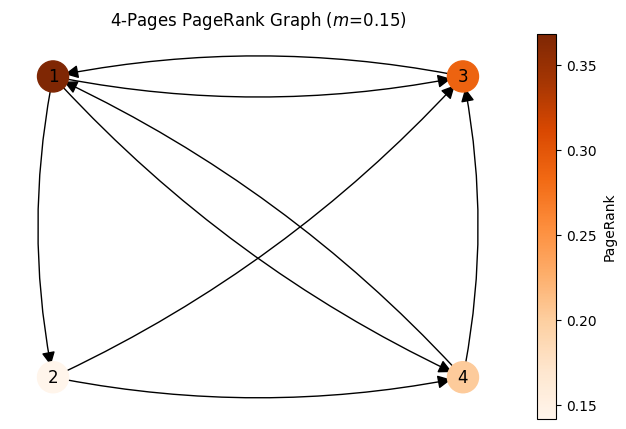

In [98]:
M,v0=compute_M_matrix(A4,0.15)
v,_,_ = pagerank_power_method_classic(M,v0)

G = nx.DiGraph()
G.add_nodes_from(range(1,5))

for i in range(4):
    for j in range(4):
        if A4[i,j] > 0:
            G.add_edge(j+1, i+1)

pos = {
    1: (0, 1),     
    3: (1, 1),     
    2: (0, 0),    
    4: (1, 0),  
}

norm = plt.Normalize(v.min(), v.max())
node_colors = plt.cm.Oranges(norm(v))  

fig, ax = plt.subplots(figsize=(8,5))

nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)

for (u,v_) in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v_)],connectionstyle='arc3,rad=0.1',arrowstyle='-|>', arrowsize=20,ax=ax)

sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
sm.set_array(v)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('PageRank')

ax.set_title(f'4-Pages PageRank Graph ($m$={0.15})')
ax.axis('off')  
plt.show()


### 5-Pages Web Graph Plot

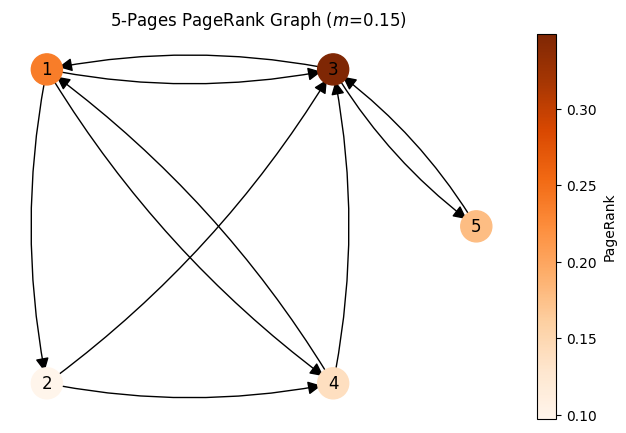

In [99]:
M,v0=compute_M_matrix(A5,0.15)
v,_,_ = pagerank_power_method_classic(M,v0)

G = nx.DiGraph()
G.add_nodes_from(range(1,5))

for i in range(5):
    for j in range(5):
        if A5[i,j] > 0:
            G.add_edge(j+1, i+1)

pos = {
    1: (0, 1),     
    3: (1, 1),     
    2: (0, 0),     
    4: (1, 0),     
    5: (1.5, 0.5)  
}

norm = plt.Normalize(v.min(), v.max())
node_colors = plt.cm.Oranges(norm(v))  

fig, ax = plt.subplots(figsize=(8,5))

nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)

for (u,v_) in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v_)],connectionstyle='arc3,rad=0.1',arrowstyle='-|>', arrowsize=20,ax=ax)

sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
sm.set_array(v)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('PageRank')

ax.set_title(f'5-Pages PageRank Graph ($m$={0.15})')
ax.axis('off') 
plt.show()

### 5-Pages Web PageRank Sensitivity with respect to $m$

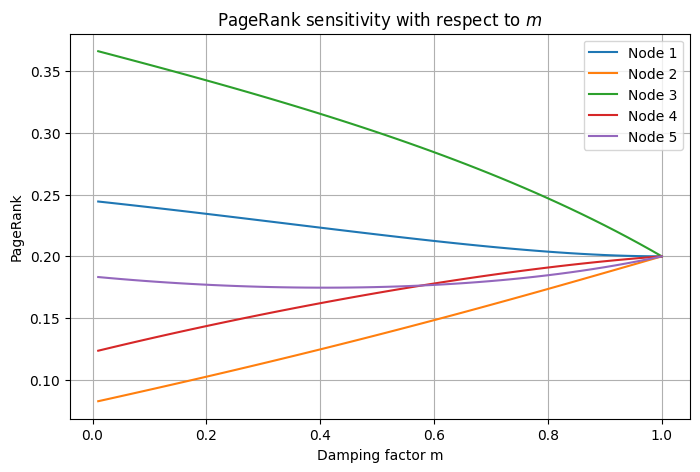

In [100]:
m_values = np.linspace(0.01, 1, 50)
pagerank_vs_m = []

for m_val in m_values:
    M,v0=compute_M_matrix(A5,m_val)
    pr,_,_ = pagerank_power_method_classic(M,v0)
    pagerank_vs_m.append(pr)

pagerank_vs_m = np.array(pagerank_vs_m)

plt.figure(figsize=(8, 5))
for i in range(5):
    plt.plot(m_values, pagerank_vs_m[:, i], label=f'Node {i+1}')

plt.xlabel('Damping factor m')
plt.ylabel('PageRank')
plt.title('PageRank sensitivity with respect to $m$')
plt.legend(loc='upper right')
plt.grid(True) 
plt.show()

### 4-Pages vs 5-Pages Web PageRank Comparison - Part 1

In [101]:
def plot_pagerank_comparison(m):
    nodes = ['1','2','3','4','5']
    M5, v0_5 = compute_M_matrix(A5, m)   
    v5, _, _ = pagerank_power_method_classic(M5, v0_5)
    M4, v0_4 = compute_M_matrix(A4, m)   
    v4, _, _ = pagerank_power_method_classic(M4, v0_4)
    
    x = np.arange(len(nodes))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(x - width/2, v5, width, label='5-Pages Web')
    ax.bar(x + width/2, np.append(v4, 0), width, label='4-Pages Web')

    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.set_xlabel('Page')
    ax.set_ylabel('PageRank')
    ax.set_title(f'PageRank Comparison: 4-Pages Web vs 5-Pages Web ($m$={m:.2f})')
    ax.legend(loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 0.5)
    
    for i, (r1, r2) in enumerate(zip(v5, np.append(v4, 0))):
        ax.text(i - width/2, r1 + 0.01, f"{r1:.3f}", ha='center', fontsize=9)
        if r2 > 0:
            ax.text(i + width/2, r2 + 0.01, f"{r2:.3f}", ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

interact(plot_pagerank_comparison, m=FloatSlider(value=0.15, min=0.01, max=1, step=0.01, description='m'));

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, min=0.01, step=0.01), Output()), _dom_…

### 4-Pages vs 5-Pages Web PageRank Comparison - Part 2

In [102]:
def plot_pagerank_difference_relative(m=0.15):
    nodes = ['1','2','3','4']    
    M5,v0_5 = compute_M_matrix(A5, m)   
    v5,_,_ = pagerank_power_method_classic(M5, v0_5)
    M4,v0_4 = compute_M_matrix(A4, m)   
    v4,_,_ = pagerank_power_method_classic(M4, v0_4)
    v5_trim = v5[:4]
    diff_rel = ((v5_trim - v4) / v4) * 100
    
    x = np.arange(len(nodes))
    fig, ax = plt.subplots(figsize=(8,5))
    bars = ax.bar(x, diff_rel, width=0.3, color='green', alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.set_title(f'Page 5 Impact on 4-Pages Web PageRank  ($m$={m:.2f})', fontsize=13)
    ax.set_xlabel('Page')
    ax.set_ylabel('Relative Difference (%)')
    ax.grid(axis='y', linestyle='--', alpha=0.7) 

    ax.bar_label(bars, labels=[f"{val:+.1f}%" for val in diff_rel], label_type='center', fontsize=10, padding=3)

    plt.tight_layout()
    plt.show()

interact(plot_pagerank_difference_relative, m=FloatSlider(value=0.15, min=0.0, max=1, step=0.01, description='m'));

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

---
## Esercise 12
Add a sixth page that links to every page of the web in the previous exercise, but to which no other page links. Rank the pages using $\mathbf{A}$, then using $\mathbf{M}$ with $m=0.15$, and compare the results.

---

### 6-Pages Web A vs M PageRank Comparison - Part 1

In [103]:
A6 = np.array([
    [0,   0,   1/2, 1/2, 0, 1/5],
    [1/3, 0,   0,   0,   0, 1/5],
    [1/3, 1/2, 0,   1/2, 1, 1/5],
    [1/3, 1/2, 0,   0,   0, 1/5],
    [0,   0,   1/2, 0,   0, 1/5],
    [0,   0,   0,   0,   0,   0]
], dtype=float)


def plot_pagerank_comparison(m):
    M, v0 = compute_M_matrix(A6, m)
    v_m, _, _ = pagerank_power_method_classic(M, v0)
    
    n6 = A6.shape[0]
    v0_a6 = np.ones(n6)
    v0_a6 /= np.linalg.norm(v0_a6, 2)
    v_a6, _, _ = pagerank_power_method_classic(A6, v0_a6)
    
    pages = np.arange(1, 7)
    bar_width = 0.35
    plt.figure(figsize=(8, 5))
    plt.bar(pages - bar_width/2, v_a6, width=bar_width, label='A')
    plt.bar(pages + bar_width/2, v_m, width=bar_width, label=f'M ($m$={m:.2f})')
    plt.ylim(0, 0.5)
    plt.xlabel('Page')
    plt.ylabel('PageRank')
    plt.title('6-Pages web PageRank Comparison: A vs M')
    plt.xticks(pages)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.tight_layout()

    for i, (r1, r2) in enumerate(zip(v_a6, v_m)):
        plt.text(i + 1 - bar_width/2, r1 + 0.01, f"{r1:.3f}", ha='center', fontsize=9)
        plt.text(i + 1 + bar_width/2, r2 + 0.01, f"{r2:.3f}", ha='center', fontsize=9)
        
    plt.show()

interact(plot_pagerank_comparison, m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m'));

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### 6-Pages Web A vs M PageRank Comparison - Part 2

In [104]:
def plot_pagerank_difference_relative_five(m=0.15):
    nodes = ['1', '2', '3', '4', '5']
    M, v0_M = compute_M_matrix(A6, m)
    v_M, _, _ = pagerank_power_method_classic(M, v0_M)
    n = A6.shape[0]
    v0_A6 = np.ones(n) / np.sqrt(n)
    v_A6, _, _ = pagerank_power_method_classic(A6, v0_A6)
    v_M_5 = v_M[:5]
    v_A6_5 = v_A6[:5]
    diff_rel = 100 * (v_M_5 - v_A6_5) / v_M_5

    x = np.arange(len(nodes))
    fig, ax = plt.subplots(figsize=(8,5))
    bars = ax.bar(x, diff_rel, width=0.3, color='darkorange', alpha=0.85)

    ax.set_xticks(x)
    ax.set_xticklabels([f'Page {i}' for i in nodes], fontsize=11)
    ax.set_title(f'Relative PageRank Difference A vs M ($m$={m:.2f})', fontsize=13, pad=15)
    ax.set_xlabel('Page', fontsize=12)
    ax.set_ylabel('Relative Difference (%)', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7) 

    ax.bar_label(bars, labels=[f"{val:+.1f}%" for val in diff_rel], label_type='center', fontsize=10, padding=3)
    plt.tight_layout()
    plt.show()

interact(plot_pagerank_difference_relative_five, m=FloatSlider(value=0.15, min=0.0, max=1, step=0.01, description='m'));

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### 6-Pages Web Graph Plot

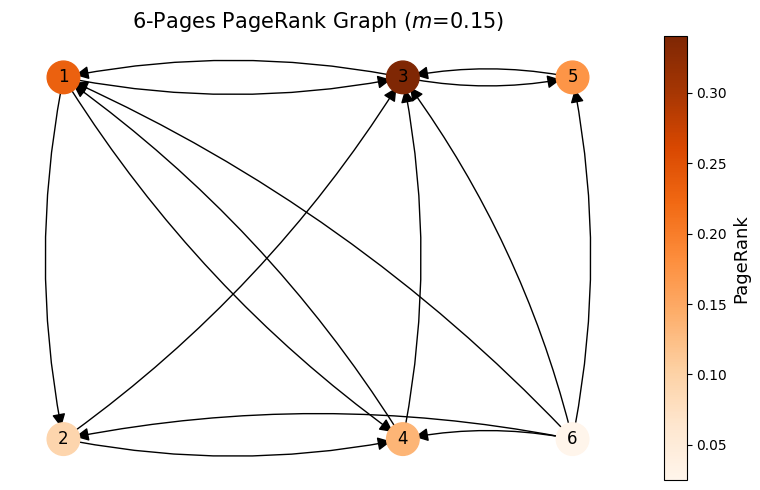

In [105]:
M, v0 = compute_M_matrix(A6, 0.15)
v, _, _ = pagerank_power_method_classic(M, v0)

G = nx.DiGraph()
G.add_nodes_from(range(1, 7)) 

for i in range(6):
    for j in range(6):
        if A6[i, j] > 0:
            G.add_edge(j+1, i+1)

pos = {
    1: (0, 1),
    3: (1, 1),
    2: (0, 0),
    4: (1, 0),
    5: (1.5, 1),
    6: (1.5, 0)  
}

norm = plt.Normalize(v.min(), v.max())
node_colors = plt.cm.Oranges(norm(v))

fig, ax = plt.subplots(figsize=(8, 5))

nx.draw_networkx_nodes(G, pos, node_size=550, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=12)

for (u, v_) in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v_)], connectionstyle='arc3,rad=0.1',arrowstyle='-|>', arrowsize=20, ax=ax)

sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
sm.set_array(v)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('PageRank', fontsize=13)

ax.set_title(f'6-Pages PageRank Graph ($m$={0.15})', fontsize=15)
ax.axis('off')
plt.tight_layout()
plt.show()

---
### Exercise 14

For the web in Exercise 11, compute the values of error: $$\|M^k \mathbf{x}_0 - \mathbf{q}\|_1$$ and the convergence ratio: $$\frac{\|M^k \mathbf{x}_0 - \mathbf{q}\|_1}{\|M^{k-1} \mathbf{x}_0 - \mathbf{q}\|_1}$$
for $k = 1, 5, 10, 50$, using an initial guess $\mathbf{x}_0$ not too close to the actual eigenvector $\mathbf{q}$ (so that you can watch the convergence).
Determine the bound $c$: $$c = \max_{1 \le j \le n} \left| 1 - 2 \min_{1 \le i \le n} M_{ij} \right|$$ and the absolute value of the second largest eigenvalue of $M$ ($|\lambda_2|$).

---

### Functions definitions

In [106]:

def calculate_c(M):
    if hasattr(M, "toarray"):
        M_dense = M.toarray()
    else:
        M_dense = M
        
    min_val_cols = np.min(M_dense, axis=0)
    
    c = np.max(np.abs(1 - 2 * min_val_cols))
    return c

def run_simulation(M, x0, v_target, steps=60):
    v = np.asarray(x0.copy()).reshape(-1)
    v_target = np.asarray(v_target).reshape(-1)
    
    errors = []
    ratios = []
    
    
    prev_error = np.sum(np.abs(v - v_target))
    errors.append(prev_error)
    ratios.append(np.nan)
    
    
    for k in range(1, steps + 1):
        v = M @ v
        v = np.asarray(v).reshape(-1)
        curr_error = np.sum(np.abs(v - v_target))
        
        if prev_error > 1e-12 and curr_error > 1e-12:
            ratio = curr_error / prev_error
        else:
            ratio = np.nan
            
        errors.append(curr_error)
        ratios.append(ratio)
        
        prev_error = curr_error
        
    return errors, ratios

### Computation of Errors Norms and Ratios 

In [107]:
m = 0.15
M, _ = compute_M_matrix(A5, m) 
n = A5.shape[0]
v0_support=np.ones(n)/n
v0, _, _ = pagerank_power_method_classic(M, v0_support, tol=1e-16, max_iter=10000)


x0 = np.ones(n) / n
errors, ratios = run_simulation(M, x0, v0, steps=55)


target_k = [1, 5, 10, 50]
results = {
    "k": target_k,
    "L1 Error": [errors[k] for k in target_k],
    "Ratio": [ratios[k] for k in target_k]
}

df = pd.DataFrame(results)

print(df.to_string(index=False, float_format="%.6e"))

 k     L1 Error        Ratio
 1 2.218875e-01 5.963605e-01
 5 3.408111e-02 5.719266e-01
10 2.799481e-03 6.143626e-01
50 7.878725e-12 6.113517e-01


### Graphs of Errors and Convergence Rates

In [108]:
def plot_interactive_analysis(A, start_strategy):

    n = A.shape[0]
    if start_strategy == 'Uniform (1/n)':
        x0 = np.ones(n) / n
    elif start_strategy == 'Page 3 (Dominant)':
        x0 = np.zeros(n); x0[2] = 1.0 
    elif start_strategy == 'Page 1 (Weak)':
        x0 = np.zeros(n); x0[0] = 1.0
    elif start_strategy == 'Random':
        np.random.seed(42)
        x0 = np.random.rand(n); x0 /= x0.sum()
    
    
    errors, ratios = run_simulation(M, x0, v0, steps=60)
    ratios_arr = np.array(ratios)
    valid_ratios = ratios_arr[~np.isnan(ratios_arr)]

    if len(valid_ratios) > 0:
        lambda_2_est = valid_ratios[-1]
    else:
        lambda_2_est = 0.0

    c_val = calculate_c(M)

    k_vals = range(len(errors))


    plt.figure(figsize=(8, 5)) 
    plt.plot(k_vals, errors, 'o-', markersize=3, label=f'Start: {start_strategy}')
    plt.yscale('log')
    plt.title("Error's decay (log scale)")
    plt.xlabel('Iteration k')
    plt.ylabel('Error')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5)) 
    plt.plot(k_vals[1:], ratios[1:], 'o-', color='orange', markersize=4, label='Observed Ratio')
    plt.axhline(y=lambda_2_est, color='green', linestyle='--', label=f'|λ2| ≈ {lambda_2_est:.3f}')
    plt.axhline(y=c_val, color='red', linestyle=':', label=f'Bound c = {c_val:.10f}')
    plt.axhline(y=1-m, color='purple', linestyle='--', label=f'1 - m = {1 - m:.3f}')
    
    plt.title('Convergence Rate')
    plt.xlabel('Iteration k')
    plt.ylim(0.5, 1.0)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.savefig("convergence rate", dpi=300, bbox_inches='tight')


print("Select the starting type to see the effect on convergence:")
interact(plot_interactive_analysis,
        A = fixed(A5),
        start_strategy=widgets.Dropdown(
            options=['Uniform (1/n)', 'Page 3 (Dominant)', 'Page 1 (Weak)', 'Random'],
            value='Uniform (1/n)',
            description='x0:'),
        
        );




Select the starting type to see the effect on convergence:


interactive(children=(Dropdown(description='x0:', options=('Uniform (1/n)', 'Page 3 (Dominant)', 'Page 1 (Weak…

### Comparison with Theoretical Contraction Coefficient and Subdominant Eigenvalue

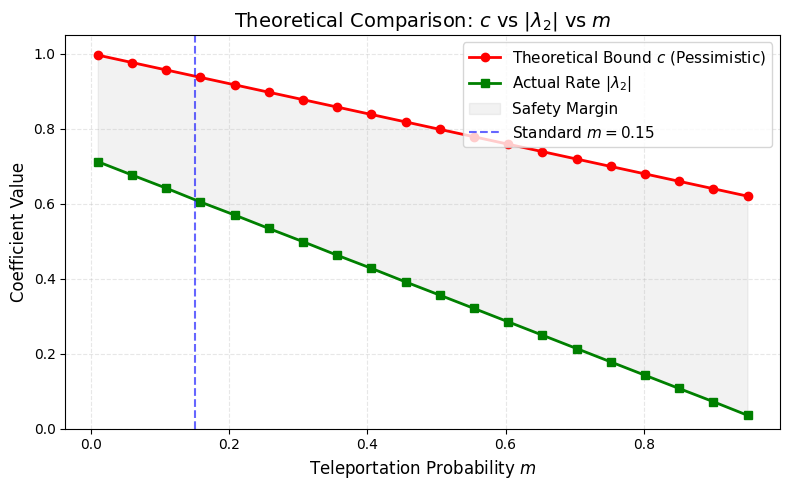

In [122]:
def plot_theoretical_sensitivity(A):
    m_values = np.linspace(0.01, 0.95, 20)
    c_vals = []
    lambda2_vals = []
    
    n = A.shape[0]
    v0 = np.ones(n) / n


    for m_val in m_values:
        M, _ = compute_M_matrix(A, m_val)
        c_vals.append(calculate_c(M))
        v_target, _, _ = pagerank_power_method_classic(M, v0, tol=1e-16, max_iter=10000)
        x0 = np.ones(n) / n
        _, ratios = run_simulation(M, x0, v_target, steps=60)
        ratios_arr = np.array(ratios)
        valid_ratios = ratios_arr[~np.isnan(ratios_arr)]
        if len(valid_ratios) > 0:
            lambda2_vals.append(valid_ratios[-1])
        else:
            lambda2_vals.append(0.0)
        

    plt.figure(figsize=(8, 5))
    plt.plot(m_values, c_vals, 'o-', color= 'red', linewidth=2, label=r'Theoretical Bound $c$ (Pessimistic)')
    plt.plot(m_values, lambda2_vals, 's-', color='green' , linewidth=2, label=r'Actual Rate $|\lambda_2|$')
    plt.fill_between(m_values, c_vals, lambda2_vals, color='gray', alpha=0.1, label='Safety Margin')
    plt.axvline(0.15, color='blue', linestyle='--', alpha=0.6, label=r'Standard $m=0.15$')
   
  
    plt.title(r'Theoretical Comparison: $c$ vs $|\lambda_2|$ vs $m$', fontsize=14)
    plt.xlabel('Teleportation Probability $m$', fontsize=12)
    plt.ylabel('Coefficient Value', fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=11, loc='upper right')
    
    plt.tight_layout()
    plt.savefig("theorical comparison", dpi=300, bbox_inches='tight')
    plt.show()
   

plot_theoretical_sensitivity(A5)

---
## Hollins Dataset 
---
### Dataset Import 

In [110]:
def preprocessing(urls_series, links_df):
    current_links = links_df.copy()
    active_ids = set(urls_series.index)
    
    while True:
        outdeg = current_links["source"].value_counts()
        non_dangling_sources = set(outdeg.index)
        dangling_to_remove = active_ids - non_dangling_sources
    
        if not dangling_to_remove:
            break
            
        active_ids -= dangling_to_remove
        
        current_links = current_links[
            current_links["source"].isin(active_ids) & 
            current_links["target"].isin(active_ids)
        ]
    
    keep_ids = sorted(list(active_ids))
    n_final = len(keep_ids)
    id2idx = {id_: i for i, id_ in enumerate(keep_ids)}

    final_outdeg = current_links["source"].value_counts()
    
    row = current_links["target"].map(id2idx)
    col = current_links["source"].map(id2idx)
    data = 1.0 / current_links["source"].map(final_outdeg)

    A_csr = csr_matrix((data, (row, col)), shape=(n_final, n_final))

    url_map_clean = pd.DataFrame({
        "matrix_index": range(n_final),
        "url": urls_series.loc[keep_ids].to_numpy()
    })
    
    return A_csr, url_map_clean


df = pd.read_csv("hollins.dat", sep=r"\s+", header=None)
N = int(df.iloc[0, 0])

urls = df.iloc[1:N+1].set_index(0)[1]

links = df.iloc[N+1:, [0, 1]].astype(int)
links.columns = ["source", "target"]

A, url_map_clean = preprocessing(urls, links)

### PageRank Optimized

In [111]:
def pagerank_sparse(A, m, max_iter=1000, tol=1e-10):
    n = A.shape[0]

    v = np.ones(n) / n
    
    lambdas = []
    errors = []
    costant= m / n

    for _ in range(max_iter):
        v_prev = v

        w = (1 - m) * (A @ v) + costant
        norm_L1 = np.sum(np.abs(w))
        v = w / norm_L1

        lambdas.append(norm_L1)

        error = np.sum(np.abs(v - v_prev))
        errors.append(error)
        if error < tol:
            break
    return v, np.array(lambdas), np.array(errors)

### Top 10 Pages PageRank Computation

In [112]:
def plot_top10_pagerank(A, url_map_clean, m=0.15, n=10):
    v, _, _ = pagerank_sparse(A, m)
    idx_top = np.argsort(v)[-n:][::-1]
    ranks_top = v[idx_top]
    urls_top = url_map_clean.iloc[idx_top]["url"].values

    plt.figure(figsize=(9, 6))
    plt.bar(range(n), ranks_top)
    plt.xticks(range(n), urls_top, rotation=45, ha='right')
    plt.ylabel("PageRank")
    plt.title(f"Top {n} URLs by PageRank ($m$={m:.2f})")
    for i, val in enumerate(ranks_top):
        plt.text(i, val + 0.01 * ranks_top.max(), f"{val:.3f}", ha="center")
    plt.tight_layout()
    plt.show()

interact(lambda m: plot_top10_pagerank(A, url_map_clean, m, n=10),m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description="m"));

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### PageRank Scatter - All Pages

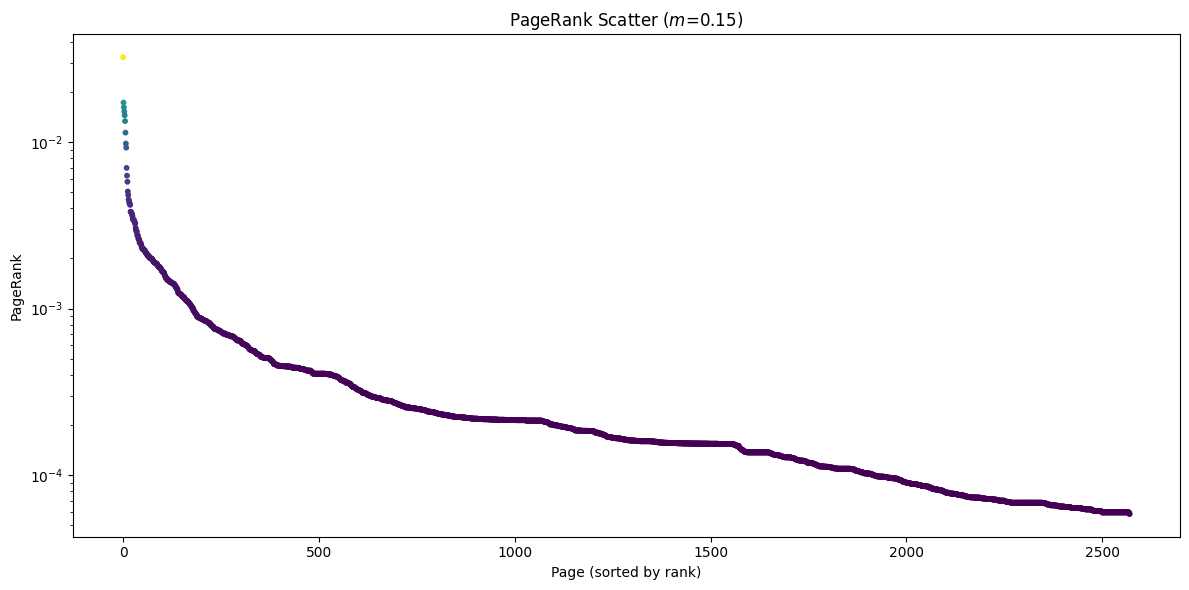

In [113]:
def plot_rank_scatter_all(A, m=0.15):
    v, _, _ = pagerank_sparse(A, m)
    ranks_sorted = np.sort(v)[::-1]

    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(ranks_sorted)), ranks_sorted, s=10, c=ranks_sorted, cmap='viridis')
    plt.xlabel('Page (sorted by rank)')
    plt.ylabel('PageRank')
    plt.title(f'PageRank Scatter ($m$={m:.2f})')
    plt.yscale('log')  
    plt.tight_layout()
    plt.show()

plot_rank_scatter_all(A, m=0.15)

### PageRank Distribution and CDF

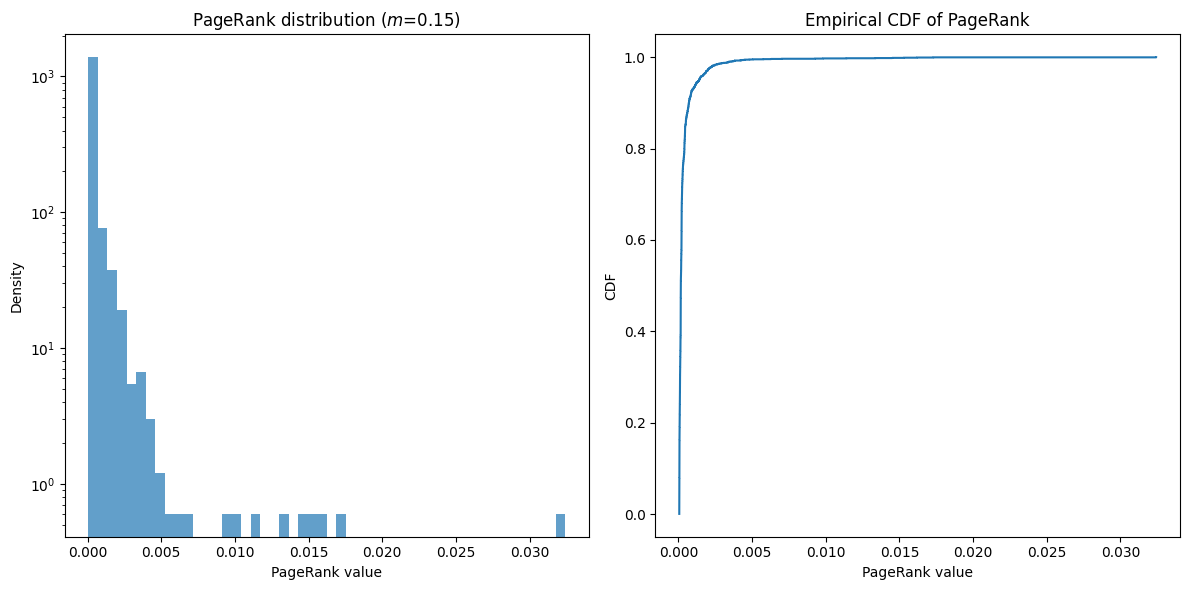

In [114]:
def plot_pagerank_hist_and_cdf(A, m=0.15, bins=50):
    v, _, _ = pagerank_sparse(A, m)
    v = np.asarray(v).reshape(-1)


    v_sorted = np.sort(v)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].hist(v, bins=bins, density=True, alpha=0.7)
    ax[0].set_xlabel("PageRank value")
    ax[0].set_ylabel("Density")
    ax[0].set_title(f"PageRank distribution ($m$={m:.2f})")
    ax[0].set_yscale("log")  

    N = len(v_sorted)
    cdf = np.arange(1, N+1) / N
    ax[1].plot(v_sorted, cdf, drawstyle="steps-post")
    ax[1].set_xlabel("PageRank value")
    ax[1].set_ylabel("CDF")
    ax[1].set_title("Empirical CDF of PageRank")

    plt.tight_layout()
    plt.show()

plot_pagerank_hist_and_cdf(A, m=0.15, bins=50)

### PageRank Concentration

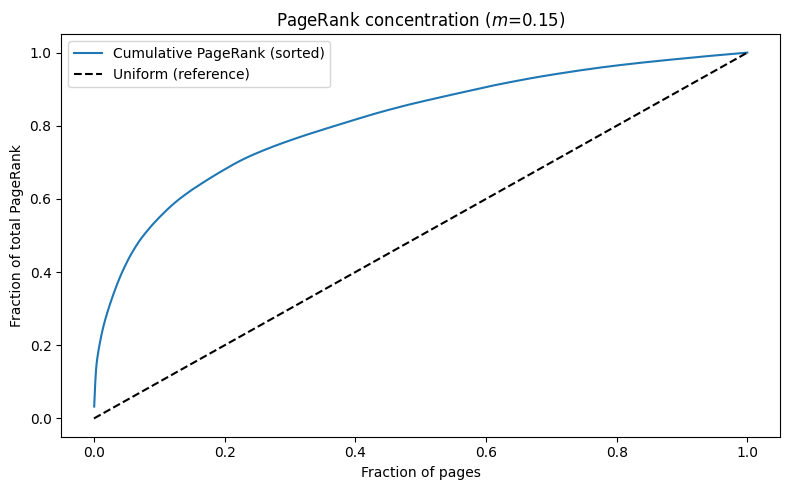

In [115]:
def plot_pagerank_lorenz(A, m=0.15):
    v, _, _ = pagerank_sparse(A, m)
    v = np.asarray(v).reshape(-1)

    v_sorted = np.sort(v)[::-1]        
    cum_rank = np.cumsum(v_sorted)     
    cum_rank /= cum_rank[-1]           

    N = len(v)
    x = np.arange(1, N+1) / N          

    plt.figure(figsize=(8, 5))
    plt.plot(x, cum_rank, label="Cumulative PageRank (sorted)")
    plt.plot([0, 1], [0, 1], "k--", label="Uniform (reference)")
    plt.xlabel("Fraction of pages")
    plt.ylabel("Fraction of total PageRank")
    plt.title(f"PageRank concentration ($m$={m:.2f})")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pagerank_lorenz(A, m=0.15)

### Functions definitions

In [116]:
def run_simulation_sparse(A, m, x0, v_target, steps=60):
    n = A.shape[0]
    v = np.asarray(x0.copy()).reshape(-1)
    v = v / np.sum(np.abs(v))
    
    errors = []
    ratios = []
    
    
    prev_error = np.sum(np.abs(v-v_target))
    errors.append(prev_error)
    ratios.append(np.nan)
    termine = m / n
    
    for k in range(steps):

        termine = (m / n) *np.sum(v)
        w = (1 - m) * (A @ v) + termine
        v = w / np.sum(np.abs(w))
        curr_error = np.sum(np.abs(v - v_target))
        
        if prev_error > 1e-16 and curr_error > 1e-16:
            ratio = curr_error / prev_error
        else:
            ratio = np.nan
            
        errors.append(curr_error)
        ratios.append(ratio)
        
        prev_error = curr_error
        
    return errors, ratios


def calculate_c_hollins(A_csr, m):

    n = A_csr.shape[0]
    A_csc = A_csr.tocsc()
    col_nnz = np.diff(A_csc.indptr)      

    col_full = np.any(col_nnz==n)

    if col_full:
        min_val=1.0/n
    else: 
        min_val = m/n 
    c = np.abs(1-2*min_val)

    return c 



### Compute errors and Ratios

In [117]:
m = 0.15
v_target, _, _=pagerank_sparse(A, m, tol=1e-16, max_iter=5000)
n = A.shape[0]
x0 = np.ones(n) / n

errors, ratios = run_simulation_sparse(A, m, x0, v_target, steps=60)

target_k = [1, 5, 20, 30, 40, 50]
results = {
    "k": target_k,
    "L1 Error": [errors[k] for k in target_k],
    "Ratio": [ratios[k] for k in target_k]
}

df = pd.DataFrame(results)

print(df.to_string(index=False, float_format="%.6e"))



 k     L1 Error        Ratio
 1 5.073038e-01 5.273232e-01
 5 8.496906e-02 7.017386e-01
20 1.571873e-03 7.954971e-01
30 1.868180e-04 8.179355e-01
40 2.670405e-05 8.289977e-01
50 4.239799e-06 8.348325e-01


### Graphs of errors and convergence rates

In [118]:
def plot_interactive_analysis_hollins(start_strategy):

    if start_strategy == 'Uniform (1/n)':
        x0 = np.ones(n) / n
    elif start_strategy == 'Page 3 (Dominant)':
        x0 = np.zeros(n); x0[2] = 1.0 
    elif start_strategy == 'Page 1 (Weak)':
        x0 = np.zeros(n); x0[0] = 1.0
    elif start_strategy == 'Random':
        np.random.seed(42)
        x0 = np.random.rand(n); x0 /= x0.sum()

    
    v_target, _, _ = pagerank_sparse(A, m, tol=1e-16, max_iter=5000)
    errors, ratios = run_simulation_sparse(A, m, x0, v_target, steps=60)

    ratios_arr = np.array(ratios)
    valid_ratios = ratios_arr[~np.isnan(ratios_arr)]

    if len(valid_ratios) > 0: 
        lambda_2 = valid_ratios[-1]
    else:
        lambda_2 = 0.0

    c_val = calculate_c_hollins(A, m)
    k_vals = range(len(errors))

    
    plt.figure(figsize=(8, 5)) 
    plt.plot(k_vals, errors, 'o-', markersize=3, label=f'Start: {start_strategy}')
    plt.yscale('log')
    plt.title("Error's decay (log scale)")
    plt.xlabel('Iteration k')
    plt.ylabel('Error')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show() 


    plt.figure(figsize=(8, 5))     
    plt.plot(k_vals[1:], ratios[1:], 'o-', color='orange', markersize=4, label='Observed Ratio')
    plt.axhline(y=lambda_2, color='green', linestyle='--', label=f'|λ2| ≈ {lambda_2:.3f}')
    plt.axhline(y=c_val, color='red', linestyle=':', label=f'Bound c = {c_val:.10f}')
    plt.axhline(y=1-m, color='purple', linestyle='--', label=f'(1 - m) = {1 - m:.3f}')
    
    plt.title('Convergence Rate')
    plt.xlabel('Iteration k')
    plt.ylim(0.5, 1.0)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("hollins_convergence.png", dpi=300, bbox_inches='tight')
    plt.show() 

print("Select the starting type to see the effect on the convergence: ")
interact(plot_interactive_analysis_hollins, 
         start_strategy=widgets.Dropdown(
             options=['Uniform (1/n)', 'Page 3 (Dominant)', 'Page 1 (Weak)', 'Random'],
             value='Uniform (1/n)',
             description='x0:') 
        );

Select the starting type to see the effect on the convergence: 


interactive(children=(Dropdown(description='x0:', options=('Uniform (1/n)', 'Page 3 (Dominant)', 'Page 1 (Weak…

### Comparison with theoretical contraction coefficient and subdominant

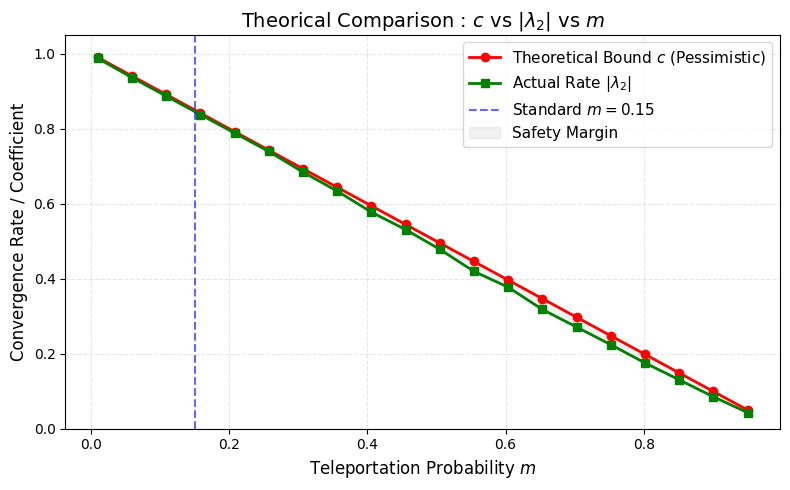

In [121]:
def plot_theoretical_sensitivity_hollins(A, steps=60):
    
    m_values = np.linspace(0.01, 0.95, 20)
    c_vals = []
    lambda2_vals = []
    theoretical_vals = []

    n = A.shape[0]

    for i, m_val in enumerate(m_values):
        c = calculate_c_hollins(A, m_val)
        c_vals.append(1-m_val)

        v_target, _, _= pagerank_sparse(A, m_val, tol=1e-16, max_iter=5000) 
        x0 = np.ones(n) / n
        errors, ratios = run_simulation_sparse(A, m_val, x0, v_target, steps=steps)
        valid_idx = -1
        for k, err in enumerate(errors):
            
            if err < 1e-10:
                valid_idx = k - 1
                break
        
        if valid_idx == -1:
            valid_idx = len(ratios) - 1
            
        if valid_idx < 0: valid_idx = 0

        if valid_idx >= len(ratios): valid_idx = len(ratios) - 1
            
        best_lambda = ratios[valid_idx]
        
        if np.isnan(best_lambda):
            best_lambda = 0.0
            
        lambda2_vals.append(best_lambda)
        
        
            

    plt.figure(figsize=(8, 5))
    plt.plot(m_values, c_vals, 'o-', color='red', linewidth=2, label=r'Theoretical Bound $c$ (Pessimistic)')
    plt.plot(m_values, lambda2_vals, 's-', color='green', linewidth=2, label=r'Actual Rate $|\lambda_2|$')
    plt.axvline(0.15, color='blue', linestyle='--', alpha=0.6, label=r'Standard $m=0.15$')
    plt.fill_between(m_values, c_vals, lambda2_vals, color='gray', alpha=0.1, label='Safety Margin')
   
    plt.title(r'Theorical Comparison : $c$ vs $|\lambda_2|$ vs $m$', fontsize=14)
    plt.xlabel('Teleportation Probability $m$', fontsize=12)
    plt.ylabel('Convergence Rate / Coefficient', fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=11, loc='upper right')
    
    plt.tight_layout()
    plt.savefig("Theorical comparison hollins", dpi=300, bbox_inches='tight')
    plt.show()
    
plot_theoretical_sensitivity_hollins(A)